In [2]:
# %pip install roboflow supervision -q

Note: you may need to restart the kernel to use updated packages.


In [1]:
import os
from dotenv import load_dotenv

load_dotenv()
from roboflow import Roboflow

# ROBOFLOW_API_KEY = userdata.get('ROBOFLOW_API_KEY')
ROBOFLOW_API_KEY = os.getenv("ROBOFLOW_API_KEY")

rf = Roboflow(api_key=ROBOFLOW_API_KEY)
project = rf.workspace("srinithi-s-tzdkb").project("fracture-detection-rhud5")
version = project.version(4)
dataset = version.download("paligemma")

loading Roboflow workspace...
loading Roboflow project...


{'image': 'n_0_2513_png_jpg.rf.1f679ff5dec5332cf06f6b9593c8437b.jpg', 'prefix': 'detect fracture', 'suffix': '<loc0390><loc0241><loc0472><loc0440> fracture'}


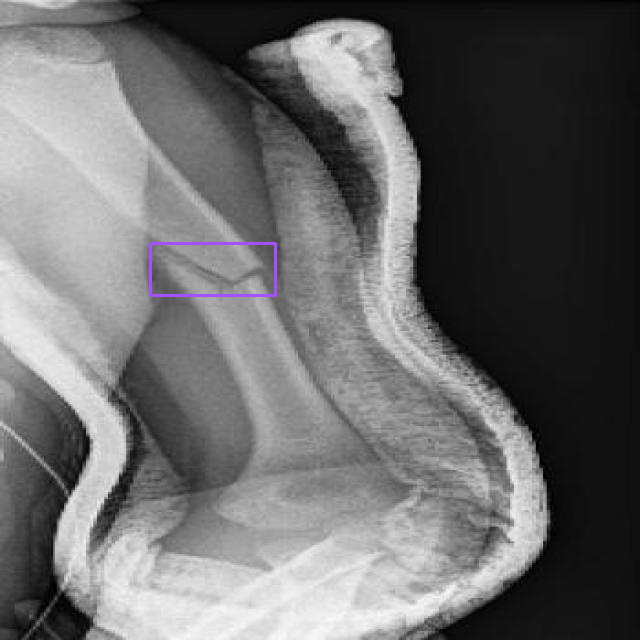

In [2]:
from PIL import Image
import json
import supervision as sv

first = json.loads(
    open(f"{dataset.location}/dataset/_annotations.train.jsonl").readline()
)
print(first)

image = Image.open(f"{dataset.location}/dataset/{first.get('image')}")
CLASSES = first.get("prefix").replace("detect ", "").split(" ; ")
# detections = from_pali_gemma(first.get("suffix"), image.size, CLASSES)
w, h = image.width, image.height
detections = sv.Detections.from_lmm(
    lmm="paligemma",
    result=first.get("suffix"),
    resolution_wh=(w, h),
    classes=CLASSES,
)
DATA_SET

sv.BoundingBoxAnnotator().annotate(image, detections)

In [3]:
import os
import sys

# TPUs with
if "COLAB_TPU_ADDR" in os.environ:
  raise "It seems you are using Colab with remote TPUs which is not supported."

# Fetch big_vision repository if python doesn't know about it and install
# dependencies needed for this notebook.
if not os.path.exists("big_vision"):
    !git clone --quiet --branch=main --depth=1 \
     https://github.com/google-research/big_vision big_vision_repo
    %mv big_vision_repo/big_vision ./
    %rm -rf big_vision_repo

# Install missing dependencies. Assume jax~=0.4.25 with GPU available.
%pip install -q "overrides" "ml_collections" "einops~=0.7" "sentencepiece"

Note: you may need to restart the kernel to use updated packages.


In [8]:
import os
import kagglehub

MODEL_PATH = "./pt_224_128.params.f16.npz"
if not os.path.exists(MODEL_PATH):
    print("Downloading the checkpoint from Kaggle, this could take a few minutes....")
    # Note: kaggle archive contains the same checkpoint in multiple formats.
    # Download only the float16 model.
    MODEL_PATH = kagglehub.model_download(
        "google/paligemma/jax/paligemma-3b-pt-224", "paligemma-3b-pt-224.f16.npz"
    )
    print(f"Model path: {MODEL_PATH}")


TOKENIZER_PATH = "./paligemma_tokenizer.model"
if not os.path.exists(TOKENIZER_PATH):
    print("Downloading the model tokenizer...")
    !gsutil cp gs://big_vision/paligemma_tokenizer.model {TOKENIZER_PATH}
    print(f"Tokenizer path: {TOKENIZER_PATH}")

Model path: /home/j2y/.cache/kagglehub/models/google/paligemma/jax/paligemma-3b-pt-224/1/paligemma-3b-pt-224.f16.npz


In [10]:
import ml_collections

# Import model definition from big_vision
from big_vision.models.proj.paligemma import paligemma
from big_vision.trainers.proj.paligemma import predict_fns

# Import big vision utilities
import big_vision.datasets.jsonl
import big_vision.utils
import big_vision.sharding
import jax
import jax.numpy as jnp

import tensorflow as tf
import sentencepiece

from IPython.core.display import display, HTML
from PIL import Image
from tqdm.notebook import tqdm
import functools


# Don't let TF use the GPU or TPUs
tf.config.set_visible_devices([], "GPU")
tf.config.set_visible_devices([], "TPU")

backend = jax.lib.xla_bridge.get_backend()
print(f"JAX version:  {jax.__version__}")
print(f"JAX platform: {backend.platform}")
print(f"JAX devices:  {jax.device_count()}")

JAX version:  0.4.28
JAX platform: gpu
JAX devices:  2


In [11]:
# Define model
model_config = ml_collections.FrozenConfigDict(
    {
        "llm": {"vocab_size": 257_152},
        "img": {
            "variant": "So400m/14",
            "pool_type": "none",
            "scan": True,
            "dtype_mm": "float16",
        },
    }
)
model = paligemma.Model(**model_config)
tokenizer = sentencepiece.SentencePieceProcessor(TOKENIZER_PATH)

# Load params - this can take up to 1 minute in T4 colabs.
params = paligemma.load(None, MODEL_PATH, model_config)

# Define `decode` function to sample outputs from the model.
decode_fn = predict_fns.get_all(model)["decode"]
decode = functools.partial(
    decode_fn, devices=jax.devices(), eos_token=tokenizer.eos_id()
)

In [12]:
import warnings


# Create a pytree mask of the trainable params.
def is_trainable_param(name, param):  # pylint: disable=unused-argument
    if name.startswith("llm/layers/attn/"):
        return True
    if name.startswith("llm/"):
        return False
    if name.startswith("img/"):
        return False
    raise ValueError(f"Unexpected param name {name}")


trainable_mask = big_vision.utils.tree_map_with_names(is_trainable_param, params)

# If more than one device is available (e.g. multiple GPUs) the parameters can
# be sharded across them to reduce HBM usage per device.
mesh = jax.sharding.Mesh(jax.devices(), ("data"))
data_sharding = jax.sharding.NamedSharding(mesh, jax.sharding.PartitionSpec("data"))
params_sharding = big_vision.sharding.infer_sharding(
    params, strategy=[(".*", 'fsdp(axis="data")')], mesh=mesh
)

# Yes: Some donated buffers are not usable.
warnings.filterwarnings("ignore", message="Some donated buffers were not usable")


@functools.partial(jax.jit, donate_argnums=(0,), static_argnums=(1,))
def maybe_cast_to_f32(params, trainable):
    return jax.tree.map(
        lambda p, m: p.astype(jnp.float32) if m else p, params, trainable
    )


# Loading all params in simultaneous - albeit much faster and more succinct -
# requires more RAM than the T4 colab runtimes have by default.
# Instead we do it param by param.
params, treedef = jax.tree.flatten(params)
sharding_leaves = jax.tree.leaves(params_sharding)
trainable_leaves = jax.tree.leaves(trainable_mask)
for idx, (sharding, trainable) in enumerate(zip(sharding_leaves, trainable_leaves)):
    params[idx] = big_vision.utils.reshard(params[idx], sharding)
    params[idx] = maybe_cast_to_f32(params[idx], trainable)
    params[idx].block_until_ready()
params = jax.tree.unflatten(treedef, params)


# Print params to show what the model is made of.
def parameter_overview(params):
    for path, arr in big_vision.utils.tree_flatten_with_names(params)[0]:
        print(f"{path:80s} {str(arr.shape):22s} {arr.dtype}")


print(" == Model params == ")
parameter_overview(params)

 == Model params == 
img/Transformer/encoder_norm/bias                                                (1152,)                float16
img/Transformer/encoder_norm/scale                                               (1152,)                float16
img/Transformer/encoderblock/LayerNorm_0/bias                                    (27, 1152)             float16
img/Transformer/encoderblock/LayerNorm_0/scale                                   (27, 1152)             float16
img/Transformer/encoderblock/LayerNorm_1/bias                                    (27, 1152)             float16
img/Transformer/encoderblock/LayerNorm_1/scale                                   (27, 1152)             float16
img/Transformer/encoderblock/MlpBlock_0/Dense_0/bias                             (27, 4304)             float16
img/Transformer/encoderblock/MlpBlock_0/Dense_0/kernel                           (27, 1152, 4304)       float16
img/Transformer/encoderblock/MlpBlock_0/Dense_1/bias                             (2

### Create model inputs

The model checkpoint you're using has already been trained on images of various aspect ratios that have been resized to 224x224 pixels, and to handle tokenized texts.

The code below defines three functions that you'll use in the next step create the model's inputs:
* **`preprocess_image`:** Normalizes the image data. In this case, pre-processing converts the passed-in image to greyscale, removes the alpha layer, and resizes the passed-in image to the size required by the model for image inputs (224x224 pixels).
* **`preprocess_tokens`:** Splits the tokens up and adds flags to mark whether a token is a prefix or suffix token. These flags will be used later on in the code, during the training step and the evaluation loop.
* **`postprocess_tokens`:** Removes any tokens left at and/or after the end-of-sequence (EOS) token and returns the remaining decoded tokens.

In [13]:
import numpy as np


def preprocess_image(image, size=224):
    """
    Model has been trained to handle images of different aspects ratios
    resized to 224x224 in the range [-1, 1]. Bilinear and antialias resize
    options are helpful to improve quality in some tasks.
    """
    image = np.asarray(image)
    if image.ndim == 2:  # Convert image without last channel into grayscale.
        image = np.stack((image,) * 3, axis=-1)
    image = image[..., :3]  # Remove alpha layer.
    assert image.shape[-1] == 3

    image = tf.constant(image)
    image = tf.image.resize(image, (size, size), method="bilinear", antialias=True)
    return image.numpy() / 127.5 - 1.0  # [0, 255]->[-1,1]


def preprocess_tokens(prefix, suffix=None, seqlen=None):
    """
    Model has been trained to handle tokenized text composed of a prefix with
    full attention and a suffix with causal attention.
    """
    separator = "\n"
    tokens = tokenizer.encode(prefix, add_bos=True) + tokenizer.encode(separator)
    mask_ar = [0] * len(tokens)  # 0 to use full attention for prefix.
    mask_loss = [0] * len(tokens)  # 0 to not use prefix tokens in the loss.

    if suffix:
        suffix = tokenizer.encode(suffix, add_eos=True)
        tokens += suffix
        mask_ar += [1] * len(suffix)  # 1 to use causal attention for suffix.
        mask_loss += [1] * len(suffix)  # 1 to use suffix tokens in the loss.

    mask_input = [1] * len(tokens)  # 1 if it's a token, 0 if padding.
    if seqlen:
        padding = [0] * max(0, seqlen - len(tokens))
        tokens = tokens[:seqlen] + padding
        mask_ar = mask_ar[:seqlen] + padding
        mask_loss = mask_loss[:seqlen] + padding
        mask_input = mask_input[:seqlen] + padding

    return jax.tree.map(np.array, (tokens, mask_ar, mask_loss, mask_input))


def postprocess_tokens(tokens):
    tokens = tokens.tolist()  # np.array to list[int]
    try:  # Remove tokens at and after EOS if any.
        eos_pos = tokens.index(tokenizer.eos_id())
        tokens = tokens[:eos_pos]
    except ValueError:
        pass
    return tokenizer.decode(tokens)

### Create the training and validation iterators

Create two iterators:

*   A **training iterator** to allow the training process to go through the data in chunks rather than processing it all at once
    *   This allows you to do some data pre-processing before use
*   A **validation iterator** that allows the training process to iterate over the validation dataset to see how well the tuned model aligned with the provided results

In [ ]:
import io

SEQLEN = 128
DATA_DIR = dataset.location + "/dataset"

train_dataset = big_vision.datasets.jsonl.DataSource(
    os.path.join(DATA_DIR, "_annotations.train.jsonl"), fopen_keys={"image": DATA_DIR}
)

val_dataset = big_vision.datasets.jsonl.DataSource(
    os.path.join(DATA_DIR, "_annotations.valid.jsonl"), fopen_keys={"image": DATA_DIR}
)


def train_data_iterator():
    """Never ending iterator over training examples."""
    # Shuffle examples and repeat so one can train for many epochs.
    dataset = train_dataset.get_tfdata().shuffle(1_000).repeat().prefetch(1)
    for example in dataset.as_numpy_iterator():
        image = Image.open(io.BytesIO(example["image"]))
        image = preprocess_image(image)

        prefix = "caption en"  # Could also be a different prefix per example.
        suffix = example["suffix"].decode().lower()
        tokens, mask_ar, mask_loss, _ = preprocess_tokens(prefix, suffix, SEQLEN)

        yield {
            "image": np.asarray(image),
            "text": np.asarray(tokens),
            "mask_ar": np.asarray(mask_ar),
            "mask_loss": np.asarray(mask_loss),
        }


def validation_data_iterator():
    """Single iterator over validation examples."""
    dataset = val_dataset.get_tfdata(ordered=True).prefetch(1)
    for example in dataset.as_numpy_iterator():
        image = Image.open(io.BytesIO(example["image"]))
        image = preprocess_image(image)

        prefix = "caption en"  # Could also be a different prefix per example.
        tokens, mask_ar, _, mask_input = preprocess_tokens(prefix, seqlen=SEQLEN)

        yield {
            "image": np.asarray(image),
            "text": np.asarray(tokens),
            "mask_ar": np.asarray(mask_ar),
            "mask_input": np.asarray(mask_input),
        }